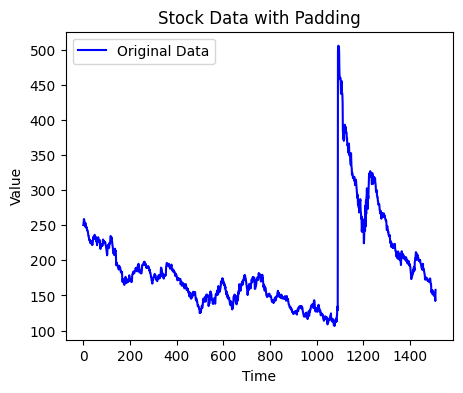

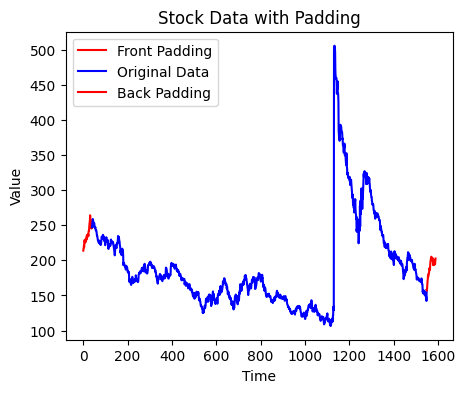

c:\Users\86137\Desktop\thesis\code\p_ftd_code.py:184: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


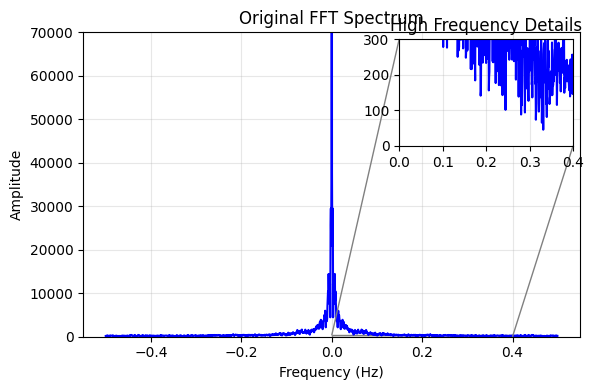

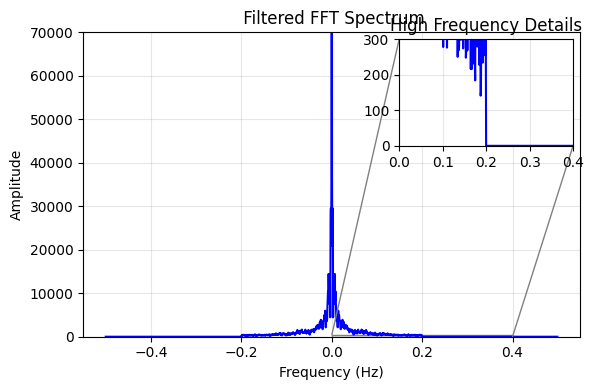

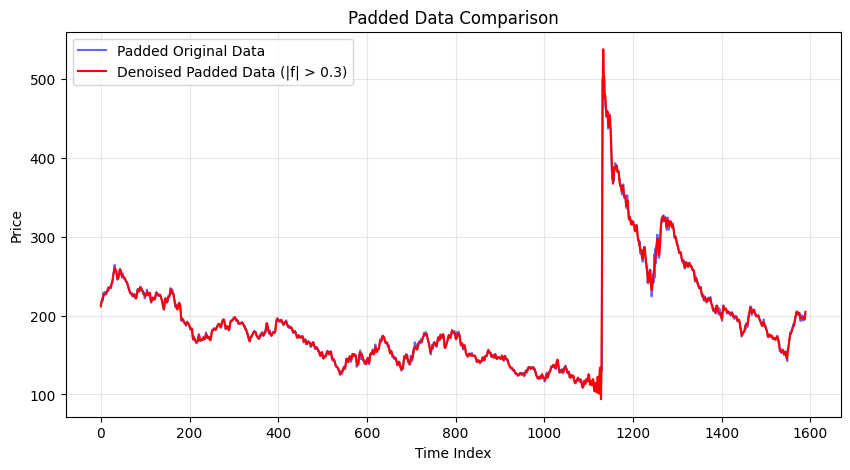

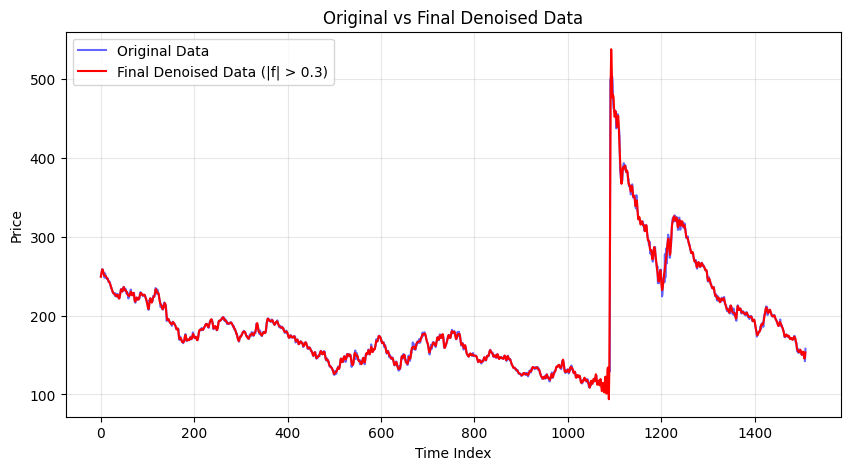

警告: 数据中不存在'adjusted close'列，将使用'close'列替代


TypeError: slice indices must be integers or None or have an __index__ method

In [1]:
# %%
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from p_ftd_code import calculate_volatility, add_padding, perform_fft, apply_threshold, inverse_fft, remove_padding

# 超参数搜索类
class HyperparameterTuner:
    def __init__(self, data_path, p_ftd_params=None, lstm_params=None):
        self.data_path = data_path
        self.p_ftd_params = p_ftd_params or {}
        self.lstm_params = lstm_params or {}
        self.data = self.load_data()
    
    def load_data(self):
        """加载SP500数据"""
        df = pd.read_csv(self.data_path, index_col='date', parse_dates=True)
        
        # 检查是否存在adjusted close列，不存在则使用close列
        if 'adjusted close' not in df.columns:
            print("警告: 数据中不存在'adjusted close'列，将使用'close'列替代")
            df['adjusted close'] = df['close']
        
        # 使用所有可用特征
        features = df[['open', 'high', 'low', 'close', 'volume']].values
        target = df['adjusted close'].values
        
        return features, target
    
    def apply_p_ftd(self, data, m, n, epsilon):
        """应用P-FTD去噪"""
        sigma1, sigma2 = calculate_volatility(data, n)
        padded_data = add_padding(data, sigma1, sigma2, m)
        fft_result = perform_fft(padded_data)
        filtered = apply_threshold(fft_result, epsilon)
        denoised_padded = inverse_fft(filtered)
        denoised_data = remove_padding(denoised_padded, len(data), m)
        return denoised_data
    
    def build_lstm_model(self, timestep, hidden_dim, feature_dim):
        """构建LSTM模型"""
        model = Sequential()
        model.add(LSTM(hidden_dim, input_shape=(timestep, feature_dim)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        return model
    
    def tune_params(self, param_grid, n_splits=3):
        """网格搜索超参数"""
        X, y = self.data
        best_score = np.inf
        best_params = {}
        
        for params in param_grid:
            # 提取P-FTD参数
            m = params['m']
            n = params['n']
            epsilon = params['epsilon']
            timestep = params['timestep']
            hidden_dim = params['hidden_dim']
            
            # 数据预处理
            scaler = MinMaxScaler()
            X_scaled = scaler.fit_transform(X)
            y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()
            
            # 应用P-FTD去噪（对每个特征单独去噪）
            X_denoised = np.zeros_like(X_scaled)
            for i in range(X_scaled.shape[1]):
                X_denoised[:, i] = self.apply_p_ftd(X_scaled[:, i], m, n, epsilon)
            
            # 构建时间序列数据
            X_train_denoised, X_test_denoised, y_train, y_test = self.split_time_series(X_denoised, y_scaled, timestep)
            X_train, X_test, _, _ = self.split_time_series(X_scaled, y_scaled, timestep)
            
            # 训练P-FTD_LSTM
            model_denoised = self.build_lstm_model(timestep, hidden_dim, X_train_denoised.shape[2])
            model_denoised.fit(X_train_denoised, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=0)
            
            # 训练原始LSTM
            model_original = self.build_lstm_model(timestep, hidden_dim, X_train.shape[2])
            model_original.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=0)
            
            # 评估
            mae_denoised = mean_absolute_error(y_test, model_denoised.predict(X_test_denoised))
            mae_original = mean_absolute_error(y_test, model_original.predict(X_test))
            
            if mae_denoised < best_score:
                best_score = mae_denoised
                best_params = {
                    **params,
                    'mae_denoised': mae_denoised,
                    'mae_original': mae_original
                }
        
        return best_params

    @staticmethod
    def split_time_series(data, target, timestep):
        """将时间序列分割为输入-输出对"""
        X = []
        y = []
        for i in range(timestep, len(data)):
            X.append(data[i-timestep:i, :])
            y.append(target[i])
        X = np.array(X)
        y = np.array(y)
        
        # 按时间顺序划分训练集(70%)、验证集(10%)和测试集(20%)
        train_size = int(0.7 * len(X))
        val_size = int(0.1 * len(X))
        test_size = len(X) - train_size - val_size
        
        X_train, X_val_test = X[:train_size], X[train_size:]
        y_train, y_val_test = y[:train_size], y[train_size:]
        X_val, X_test = X_val_test[:val_size], X_val_test[val_size:]
        y_val, y_test = y_val_test[:val_size], y_val_test[val_size:]
        
        return X_train, X_test, y_train, y_test

# %% 主程序
if __name__ == '__main__':
    # 1. 初始化调优器，指定数据路径
    tuner = HyperparameterTuner(data_path="SP500.csv")
    
    # 2. 超参数搜索网格（避免直接使用文献参数）
    param_grid = [
        {
            'm': [20, 40, 60],       # 填充大小
            'n': [10, 20, 40],       # 波动率窗口
            'epsilon': [0.1, 0.2, 0.3],  # 频率阈值
            'timestep': [20, 60, 120],   # 时间步长
            'hidden_dim': [10, 20, 30]    # LSTM隐藏层维度
        }
    ]
    
    # 3. 执行网格搜索（耗时较长，可改为随机搜索或减少参数范围）
    best_params = tuner.tune_params(param_grid)
    
    # 4. 输出最优参数
    print("最优P-FTD参数：")
    print(f"填充大小m: {best_params['m']}")
    print(f"波动率窗口n: {best_params['n']}")
    print(f"频率阈值ε: {best_params['epsilon']}")
    print(f"LSTM时间步长: {best_params['timestep']}")
    print(f"隐藏层维度: {best_params['hidden_dim']}")
    
    # 5. 重新训练最优模型并评估
    X, y = tuner.data
    
    # 数据预处理
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()
    
    # 应用最优P-FTD参数
    X_denoised = np.zeros_like(X_scaled)
    for i in range(X_scaled.shape[1]):
        X_denoised[:, i] = tuner.apply_p_ftd(X_scaled[:, i], best_params['m'], best_params['n'], best_params['epsilon'])
    
    # 分割数据
    timestep = best_params['timestep']
    X_train_denoised, X_test_denoised, y_train, y_test = tuner.split_time_series(X_denoised, y_scaled, timestep)
    X_train, X_test, _, _ = tuner.split_time_series(X_scaled, y_scaled, timestep)
    
    # 构建模型
    feature_dim = X_train.shape[2]
    model_pftd_lstm = tuner.build_lstm_model(timestep, best_params['hidden_dim'], feature_dim)
    model_lstm = tuner.build_lstm_model(timestep, best_params['hidden_dim'], feature_dim)
    
    # 训练
    print("训练P-FTD_LSTM模型...")
    model_pftd_lstm.fit(X_train_denoised, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)
    
    print("训练原始LSTM模型...")
    model_lstm.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)
    
    # 预测
    y_pred_pftd = model_pftd_lstm.predict(X_test_denoised).flatten()
    y_pred_lstm = model_lstm.predict(X_test).flatten()
    
    # 反归一化
    y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_pftd_original = scaler.inverse_transform(y_pred_pftd.reshape(-1, 1)).flatten()
    y_pred_lstm_original = scaler.inverse_transform(y_pred_lstm.reshape(-1, 1)).flatten()
    
    # 计算评估指标
    def calculate_metrics(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        return mae, rmse, mape
    
    mae_pftd, rmse_pftd, mape_pftd = calculate_metrics(y_test_original, y_pred_pftd_original)
    mae_lstm, rmse_lstm, mape_lstm = calculate_metrics(y_test_original, y_pred_lstm_original)
    
    # 打印结果（类似文献表4格式）
    print("\n============= S&P500 对比结果 =============")
    print("模型          | MAE       | RMSE      | MAPE (%)")
    print(f"P-FTD_LSTM    | {mae_pftd:.3f} | {rmse_pftd:.3f} | {mape_pftd:.3f}")
    print(f"LSTM          | {mae_lstm:.3f} | {rmse_lstm:.3f} | {mape_lstm:.3f}")
    
    # 可视化预测结果
    plt.figure(figsize=(14, 7))
    plt.plot(y_test_original, label='实际价格', alpha=0.7, color='black')
    plt.plot(y_pred_pftd_original, label='P-FTD_LSTM 预测', alpha=0.7, color='blue')
    plt.plot(y_pred_lstm_original, label='LSTM 预测', alpha=0.7, color='red')
    plt.title('S&P500 收盘价预测对比')
    plt.xlabel('时间步')
    plt.ylabel('价格')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('prediction_comparison.png', dpi=300)
    plt.show()
    
    # 保存预测结果到CSV
    dates = pd.read_csv("SP500.csv")['date'].iloc[-len(y_test_original):].values
    results_df = pd.DataFrame({
        'date': dates,
        'actual_price': y_test_original,
        'pftd_lstm_prediction': y_pred_pftd_original,
        'lstm_prediction': y_pred_lstm_original
    })
    results_df.to_csv('prediction_results.csv', index=False)
    print("预测结果已保存至 prediction_results.csv")